In [1]:
import sys
sys.path.append("../")  # remonte d'un dossier

from Segmentation_methods.Dataset.Custom import Custom
from Segmentation_methods.utils import show_sample
from Segmentation_methods.utils import inference

import os
import pickle
from sklearn.model_selection import train_test_split
from Segmentation_methods.train import train_model
from Segmentation_methods.Modeles.Model import SegmentationModelBuilder


import torch
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from torch import nn, optim


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/local/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/local/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/ana

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/local/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/local/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/ana

AttributeError: _ARRAY_API not found

# 1) Split, Visualize and prepare data for training 

In [2]:
# Load the original data
with open(images_path, "rb") as f:
    X = pickle.load(f)

with open(masks_path, "rb") as f:
    Y = pickle.load(f)

print("Original shape:", X.shape, Y.shape)

# Split (same shuffle)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Directory to save the splits
save_dir = os.path.join(WORKDIR, "Segmentation_methods", "Dataset", "Splits")
os.makedirs(save_dir, exist_ok=True)

with open(os.path.join(save_dir, "X_train.pkl"), "wb") as f:
    pickle.dump(X_train, f)

with open(os.path.join(save_dir, "X_test.pkl"), "wb") as f:
    pickle.dump(X_test, f)

with open(os.path.join(save_dir, "Y_train.pkl"), "wb") as f:
    pickle.dump(Y_train, f)

with open(os.path.join(save_dir, "Y_test.pkl"), "wb") as f:
    pickle.dump(Y_test, f)

print("Train shape:", X_train.shape, Y_train.shape)
print("Test shape:", X_test.shape, Y_test.shape)

NameError: name 'images_path' is not defined

In [2]:
images_train = os.path.join("Dataset", "Splits", "X_train.pkl")
masks_train = os.path.join("Dataset", "Splits", "Y_train.pkl")
Train_dataset = Custom(image_pkl_path=images_train, mask_pkl_path=masks_train)

images_test = os.path.join("Dataset", "Splits", "X_test.pkl")
masks_test = os.path.join("Dataset", "Splits", "Y_test.pkl")
Test_dataset = Custom(image_pkl_path=images_test, mask_pkl_path=masks_test)

# Dataloaders
train_loader = DataLoader(Train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(Test_dataset, batch_size=32, shuffle=False)

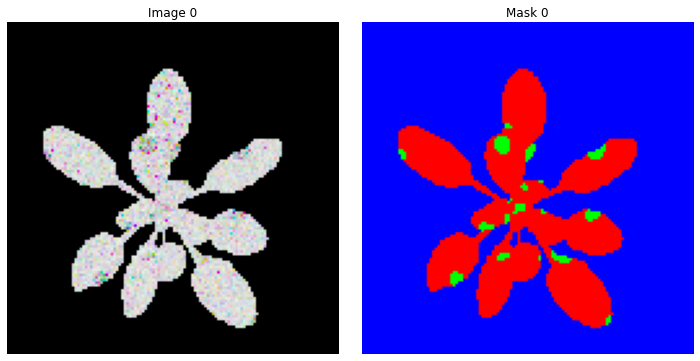

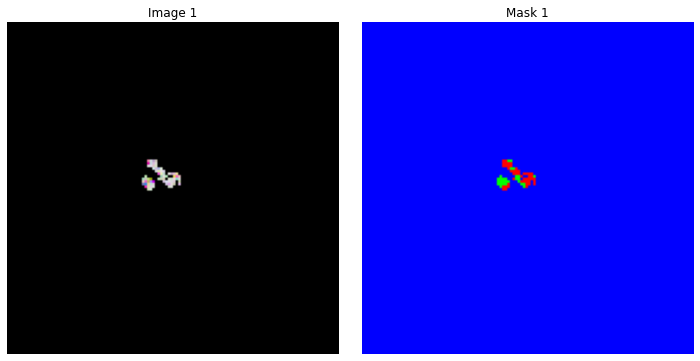

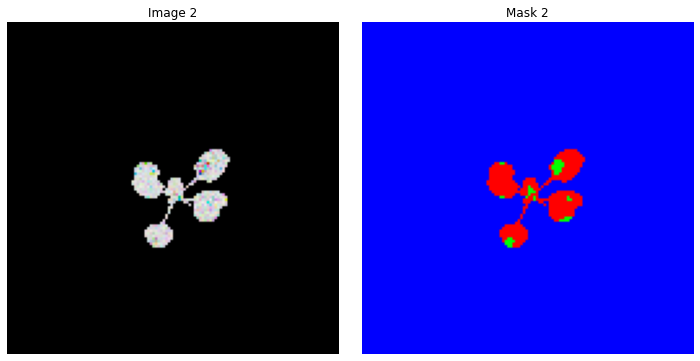

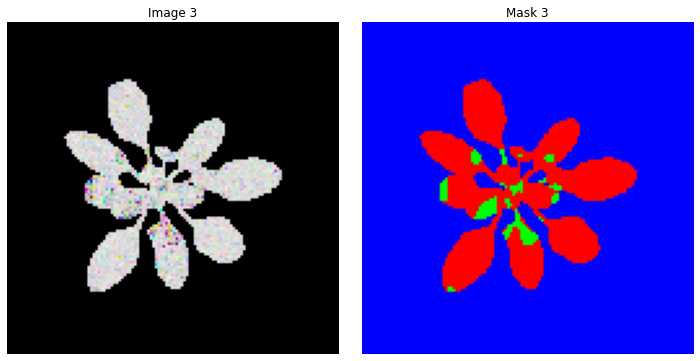

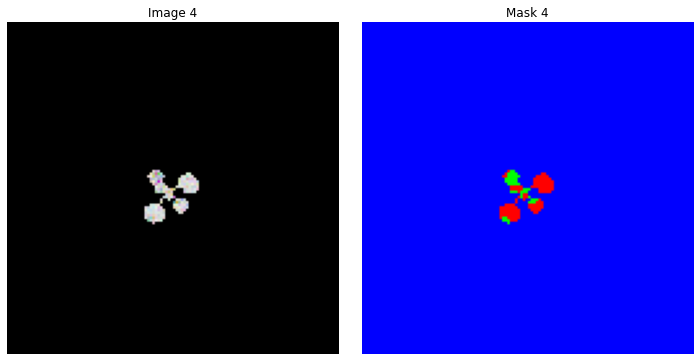

In [3]:
for i in range(5):
    image, mask_rgb, _ = Train_dataset[i]
    show_sample(image, mask_rgb, index=i)
    
# Notice the difference in the scale in the images

# Training phase

## UNet

In [3]:
backbone_name="resnet34"
device = torch.device("cuda:3")
arch="unet"
save_path = f"{arch}_{backbone_name}_best_model.pth"

In [4]:
builder = SegmentationModelBuilder(backbone_name, arch, num_classes=3, encoder_weights="imagenet")
model = builder.build()

In [5]:
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track


Epoch 1/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.14it/s]


Train Loss: 0.160416
Val Loss: 0.041558 | Mean Jaccard: 0.696018 | Mean Dice: 0.747943 | Mean Recall: 0.7213958501815796 | Mean Precision: 0.8995036482810974 | Mean ConfIndex: -0.7365951538085938


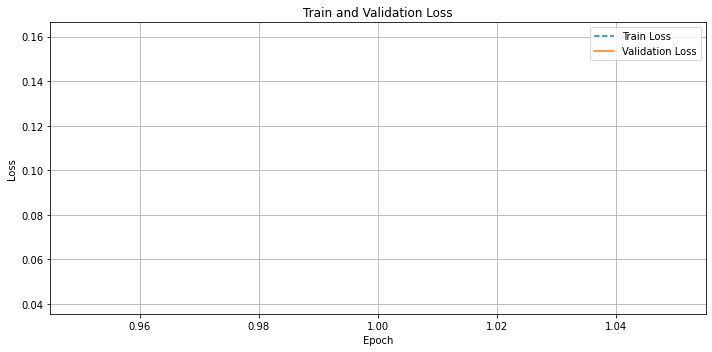


Epoch 2/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.25it/s]


Train Loss: 0.032591
Val Loss: 0.033674 | Mean Jaccard: 0.798435 | Mean Dice: 0.866383 | Mean Recall: 0.8848984837532043 | Mean Precision: 0.8520050048828125 | Mean ConfIndex: 0.5919358134269714


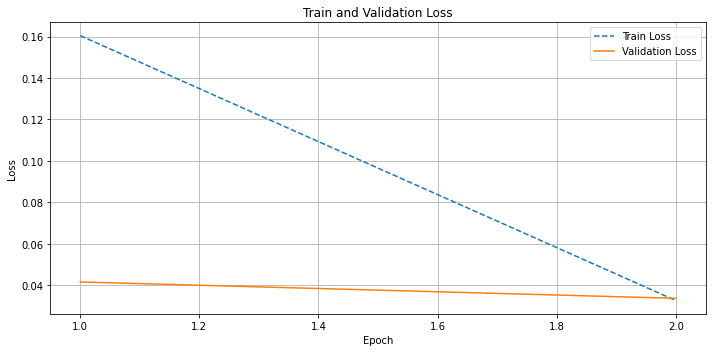


Epoch 3/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.28it/s]


Train Loss: 0.022787
Val Loss: 0.027668 | Mean Jaccard: 0.812122 | Mean Dice: 0.878035 | Mean Recall: 0.907436728477478 | Mean Precision: 0.8570077419281006 | Mean ConfIndex: 0.64409339427948


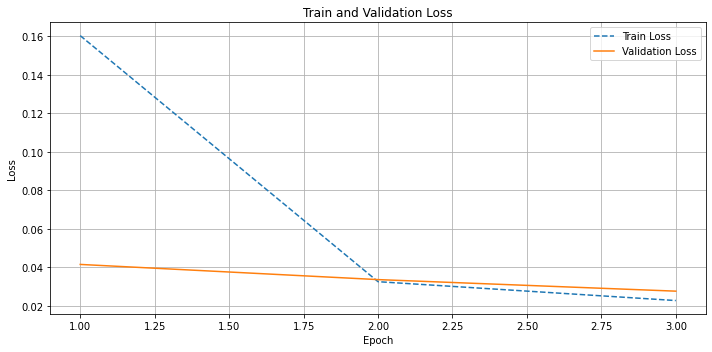


Epoch 4/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.30it/s]


Train Loss: 0.020160
Val Loss: 0.017934 | Mean Jaccard: 0.835807 | Mean Dice: 0.895804 | Mean Recall: 0.8639535903930664 | Mean Precision: 0.944104790687561 | Mean ConfIndex: 0.7109359502792358


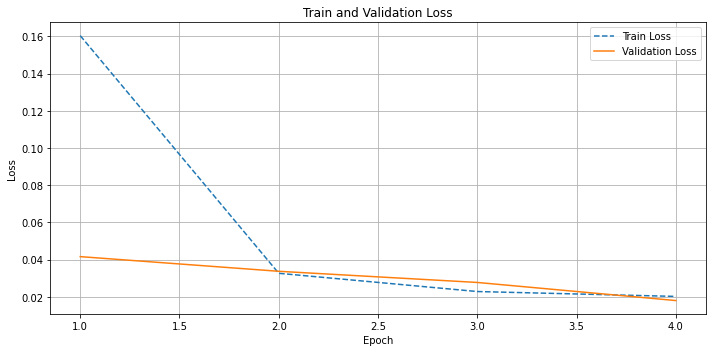


Epoch 5/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.14it/s]


Train Loss: 0.017623
Val Loss: 0.016408 | Mean Jaccard: 0.852239 | Mean Dice: 0.908923 | Mean Recall: 0.8908487558364868 | Mean Precision: 0.9310968518257141 | Mean ConfIndex: 0.7600478529930115


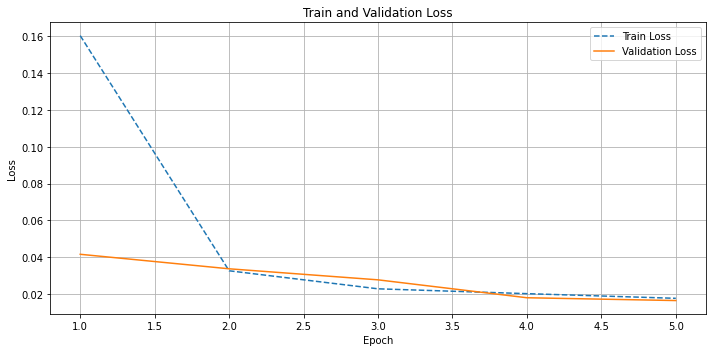


Epoch 6/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.22it/s]


Train Loss: 0.016088
Val Loss: 0.016207 | Mean Jaccard: 0.860579 | Mean Dice: 0.915407 | Mean Recall: 0.9173383712768555 | Mean Precision: 0.9136073589324951 | Mean ConfIndex: 0.7829192876815796


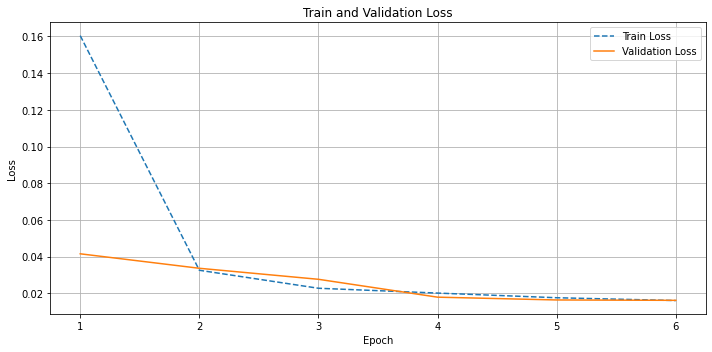


Epoch 7/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.14it/s]


Train Loss: 0.015158
Val Loss: 0.018021 | Mean Jaccard: 0.827225 | Mean Dice: 0.888582 | Mean Recall: 0.8491564989089966 | Mean Precision: 0.9576637148857117 | Mean ConfIndex: 0.6813451051712036


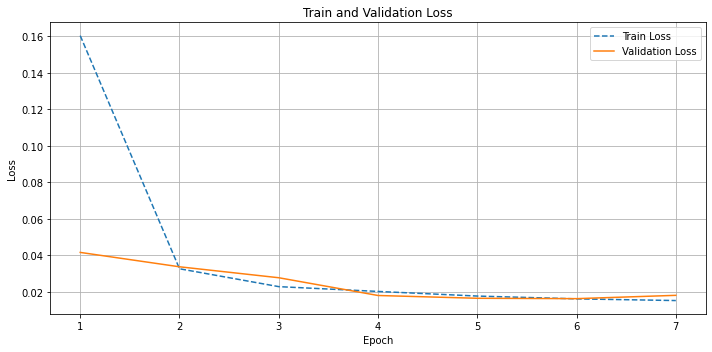


Epoch 8/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.37it/s]


Train Loss: 0.014834
Val Loss: 0.021111 | Mean Jaccard: 0.837915 | Mean Dice: 0.898885 | Mean Recall: 0.9340976476669312 | Mean Precision: 0.8738031983375549 | Mean ConfIndex: 0.7272719144821167


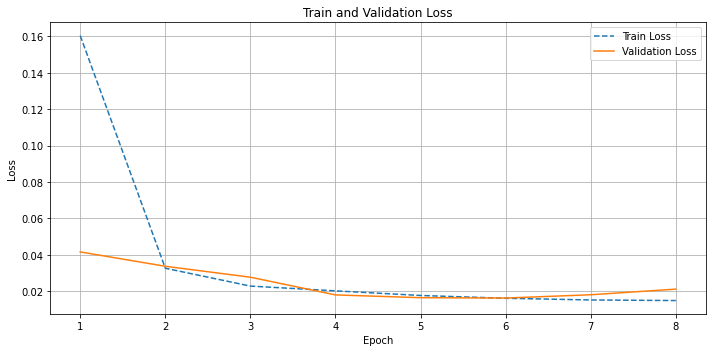


Epoch 9/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.39it/s]


Train Loss: 0.014322
Val Loss: 0.014458 | Mean Jaccard: 0.854879 | Mean Dice: 0.910670 | Mean Recall: 0.8792609572410583 | Mean Precision: 0.9563246369361877 | Mean ConfIndex: 0.7653881311416626


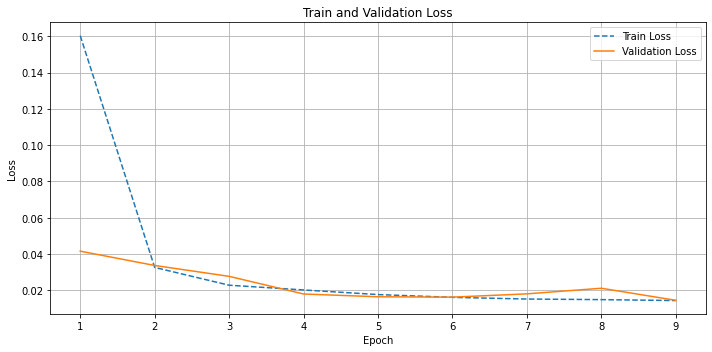


Epoch 10/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.23it/s]


Train Loss: 0.013971
Val Loss: 0.013677 | Mean Jaccard: 0.871806 | Mean Dice: 0.923398 | Mean Recall: 0.9150292873382568 | Mean Precision: 0.9325510263442993 | Mean ConfIndex: 0.808289647102356


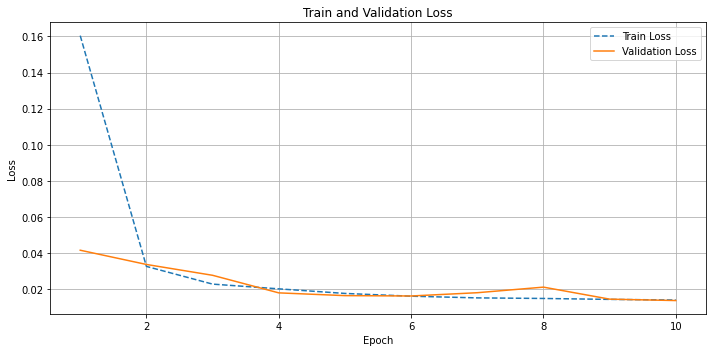


Epoch 11/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.34it/s]


Train Loss: 0.013737
Val Loss: 0.013519 | Mean Jaccard: 0.868635 | Mean Dice: 0.921040 | Mean Recall: 0.9064854979515076 | Mean Precision: 0.9381221532821655 | Mean ConfIndex: 0.8005770444869995


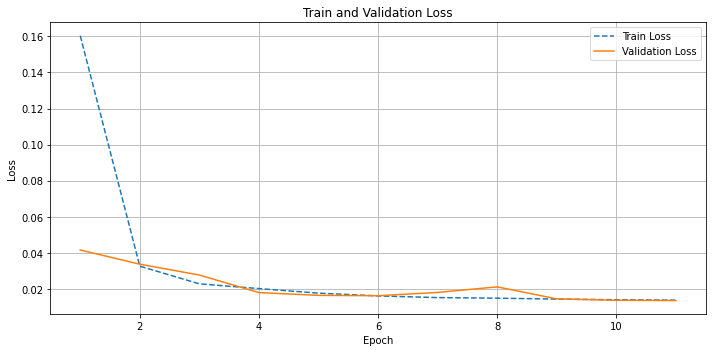


Epoch 12/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.31it/s]


Train Loss: 0.013252
Val Loss: 0.015498 | Mean Jaccard: 0.838823 | Mean Dice: 0.897990 | Mean Recall: 0.8577269315719604 | Mean Precision: 0.9669905304908752 | Mean ConfIndex: 0.7184871435165405


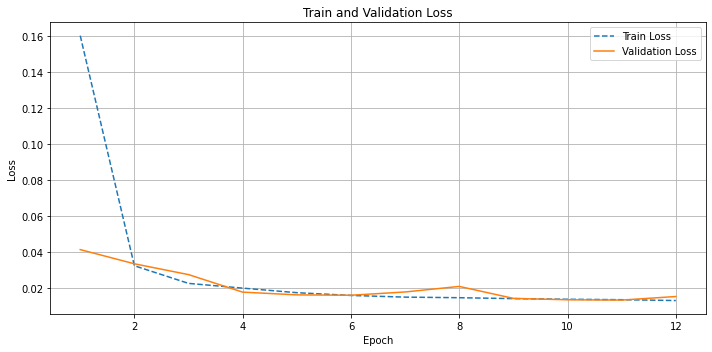


Epoch 13/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.34it/s]


Train Loss: 0.012950
Val Loss: 0.020728 | Mean Jaccard: 0.803340 | Mean Dice: 0.867534 | Mean Recall: 0.8211702108383179 | Mean Precision: 0.9712579250335693 | Mean ConfIndex: 0.5847986936569214


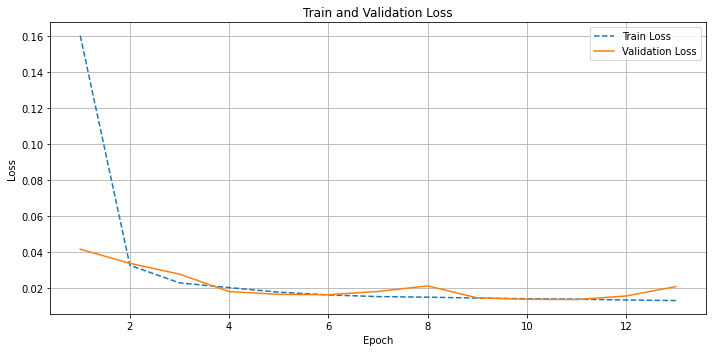


Epoch 14/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.34it/s]


Train Loss: 0.012631
Val Loss: 0.015219 | Mean Jaccard: 0.845435 | Mean Dice: 0.903284 | Mean Recall: 0.8650006651878357 | Mean Precision: 0.9658882021903992 | Mean ConfIndex: 0.7386692762374878


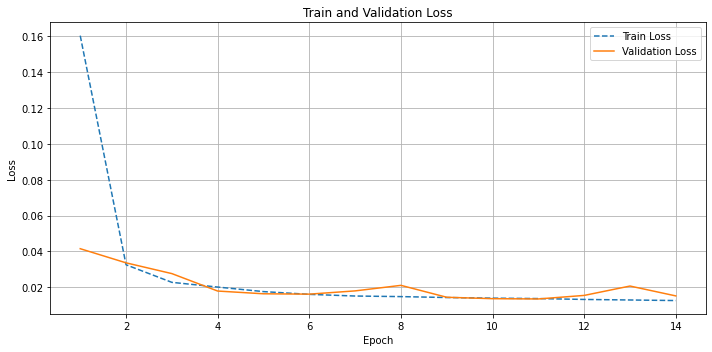


Epoch 15/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.33it/s]


Train Loss: 0.012315
Val Loss: 0.014429 | Mean Jaccard: 0.854288 | Mean Dice: 0.910182 | Mean Recall: 0.8759300708770752 | Mean Precision: 0.9619066715240479 | Mean ConfIndex: 0.7635794878005981


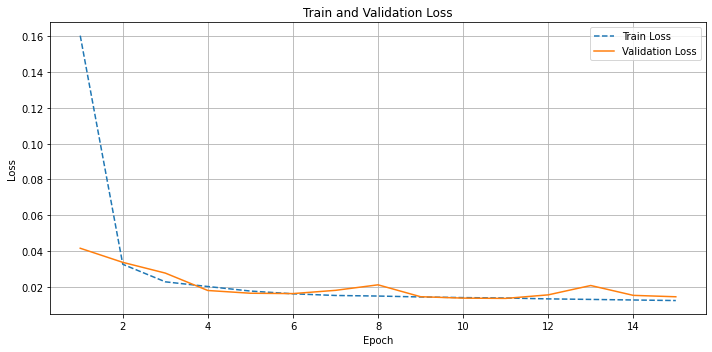


Epoch 16/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.37it/s]


Train Loss: 0.012491
Val Loss: 1.938697 | Mean Jaccard: 0.403466 | Mean Dice: 0.481411 | Mean Recall: 0.44389864802360535 | Mean Precision: nan | Mean ConfIndex: -inf


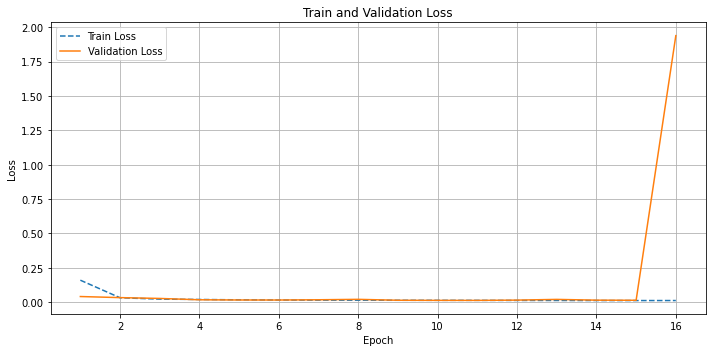


Epoch 17/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.24it/s]


Train Loss: 0.013828
Val Loss: 0.013621 | Mean Jaccard: 0.858775 | Mean Dice: 0.913558 | Mean Recall: 0.8797141909599304 | Mean Precision: 0.964053213596344 | Mean ConfIndex: 0.7751498222351074


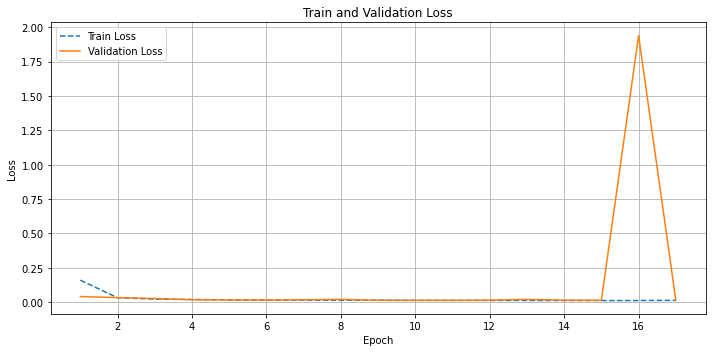


Epoch 18/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.44it/s]


Train Loss: 0.012433
Val Loss: 0.014758 | Mean Jaccard: 0.848671 | Mean Dice: 0.905792 | Mean Recall: 0.8671668171882629 | Mean Precision: 0.9688552021980286 | Mean ConfIndex: 0.7477490901947021


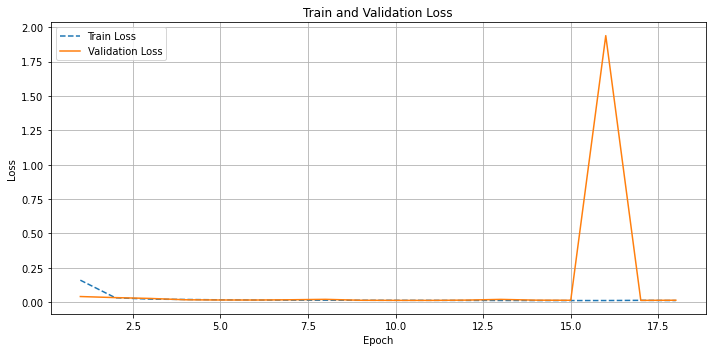


Epoch 19/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Train Loss: 0.012016
Val Loss: 0.015073 | Mean Jaccard: 0.847218 | Mean Dice: 0.904662 | Mean Recall: 0.8659970164299011 | Mean Precision: 0.9680671691894531 | Mean ConfIndex: 0.7436495423316956


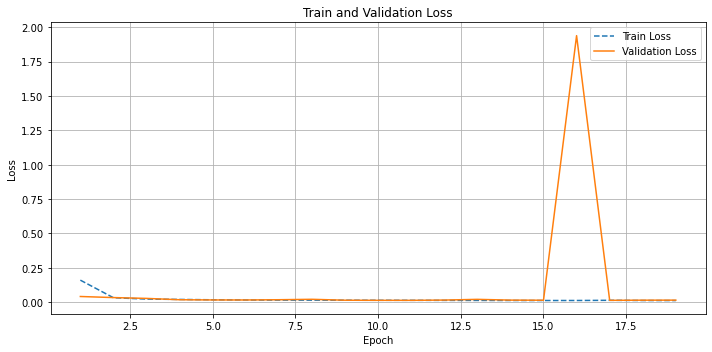


Epoch 20/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.36it/s]


Train Loss: 0.011864
Val Loss: 0.018107 | Mean Jaccard: 0.854334 | Mean Dice: 0.911310 | Mean Recall: 0.9499468207359314 | Mean Precision: 0.8839929103851318 | Mean ConfIndex: 0.7708332538604736


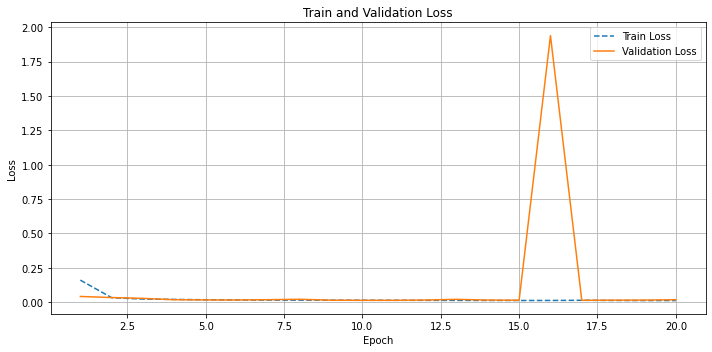


Epoch 21/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.37it/s]


Train Loss: 0.011294
Val Loss: 0.012890 | Mean Jaccard: 0.868283 | Mean Dice: 0.920639 | Mean Recall: 0.8925055265426636 | Mean Precision: 0.959133505821228 | Mean ConfIndex: 0.7988545298576355


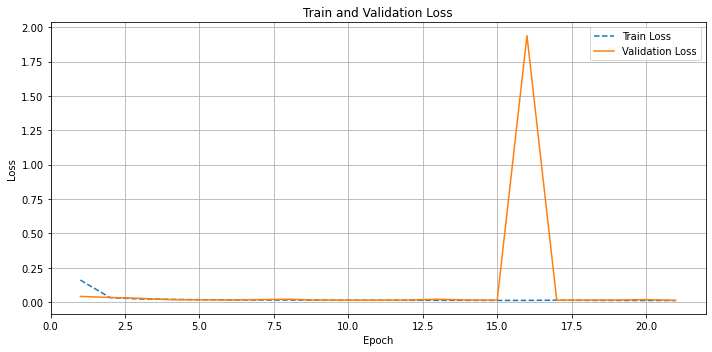


Epoch 22/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.26it/s]


Train Loss: 0.011084
Val Loss: 0.019395 | Mean Jaccard: 0.811407 | Mean Dice: 0.874755 | Mean Recall: 0.8280770778656006 | Mean Precision: 0.9755637049674988 | Mean ConfIndex: 0.6195642948150635


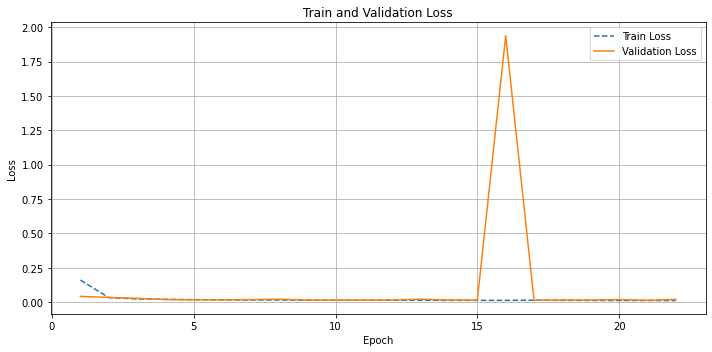


Epoch 23/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.41it/s]


Train Loss: 0.010779
Val Loss: 0.012112 | Mean Jaccard: 0.877971 | Mean Dice: 0.927657 | Mean Recall: 0.9095854163169861 | Mean Precision: 0.9494540691375732 | Mean ConfIndex: 0.8212271332740784


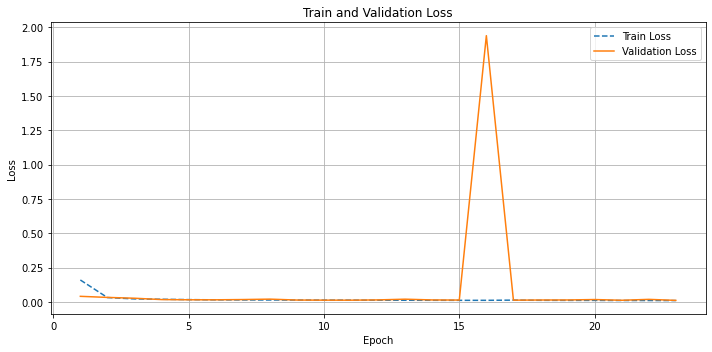


Epoch 24/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.38it/s]


Train Loss: 0.010812
Val Loss: 0.016340 | Mean Jaccard: 0.863443 | Mean Dice: 0.917782 | Mean Recall: 0.9446036219596863 | Mean Precision: 0.8967650532722473 | Mean ConfIndex: 0.7915460467338562


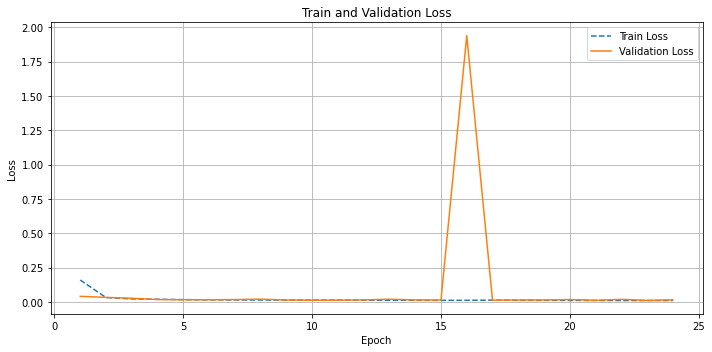


Epoch 25/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.31it/s]


Train Loss: 0.010467
Val Loss: 0.014282 | Mean Jaccard: 0.858677 | Mean Dice: 0.913486 | Mean Recall: 0.8796827793121338 | Mean Precision: 0.9640073776245117 | Mean ConfIndex: 0.7749347686767578


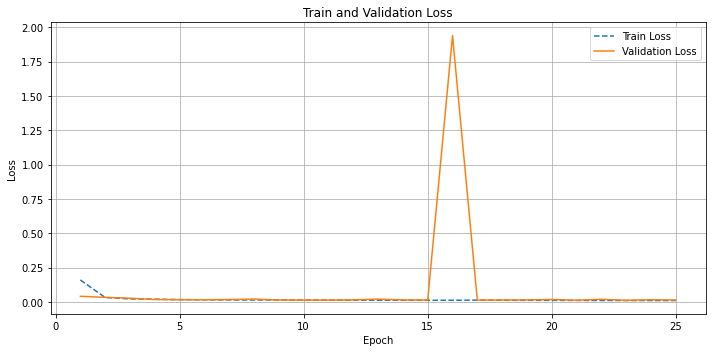


Epoch 26/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.34it/s]


Train Loss: 0.009784
Val Loss: 0.013149 | Mean Jaccard: 0.869352 | Mean Dice: 0.921418 | Mean Recall: 0.8928790092468262 | Mean Precision: 0.9605765342712402 | Mean ConfIndex: 0.8014014959335327


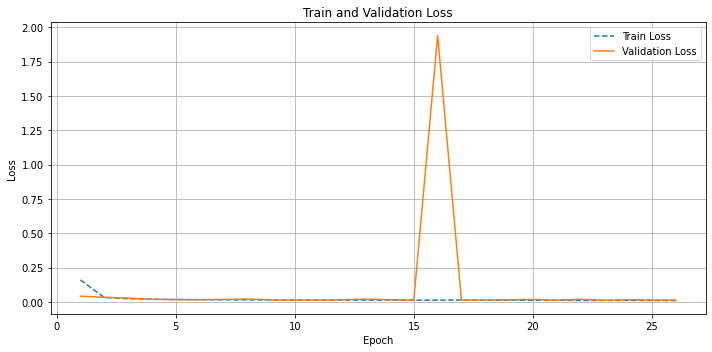


Epoch 27/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.27it/s]


Train Loss: 0.009430
Val Loss: 0.012440 | Mean Jaccard: 0.877079 | Mean Dice: 0.927021 | Mean Recall: 0.9079705476760864 | Mean Precision: 0.9502725005149841 | Mean ConfIndex: 0.819245457649231


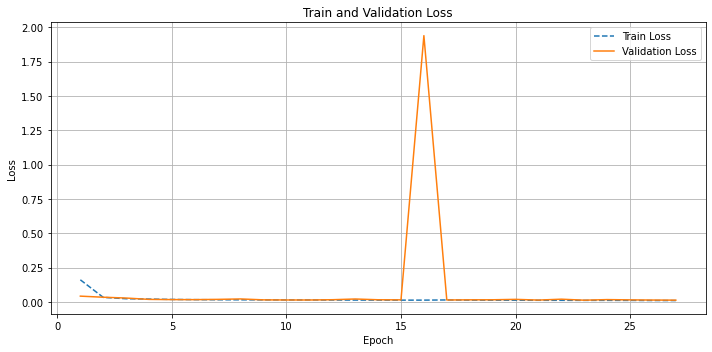


Epoch 28/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.41it/s]


Train Loss: 0.009220
Val Loss: 0.013053 | Mean Jaccard: 0.878684 | Mean Dice: 0.928359 | Mean Recall: 0.9327167868614197 | Mean Precision: 0.9242127537727356 | Mean ConfIndex: 0.8239318132400513


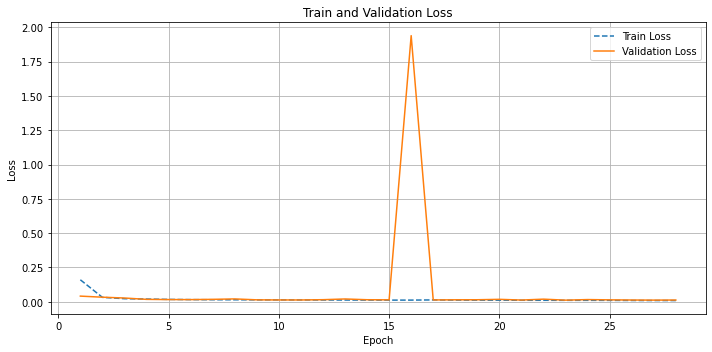


Epoch 29/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.48it/s]


Train Loss: 0.009144
Val Loss: 0.013876 | Mean Jaccard: 0.868291 | Mean Dice: 0.920648 | Mean Recall: 0.8919660449028015 | Mean Precision: 0.9601403474807739 | Mean ConfIndex: 0.7989131212234497


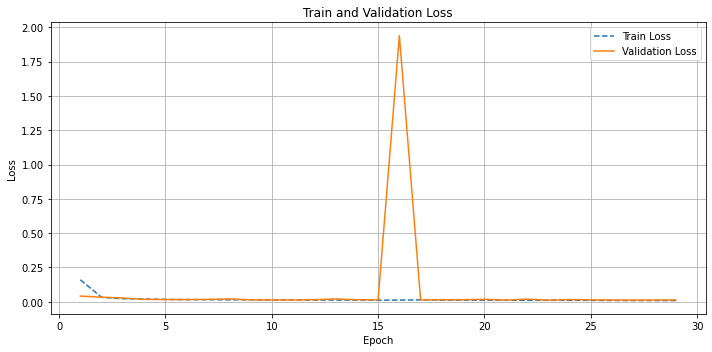


Epoch 30/30


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:14<00:00,  9.22it/s]


Train Loss: 0.008621
Val Loss: 0.014312 | Mean Jaccard: 0.870851 | Mean Dice: 0.922929 | Mean Recall: 0.9352240562438965 | Mean Precision: 0.9120050072669983 | Mean ConfIndex: 0.8074135184288025


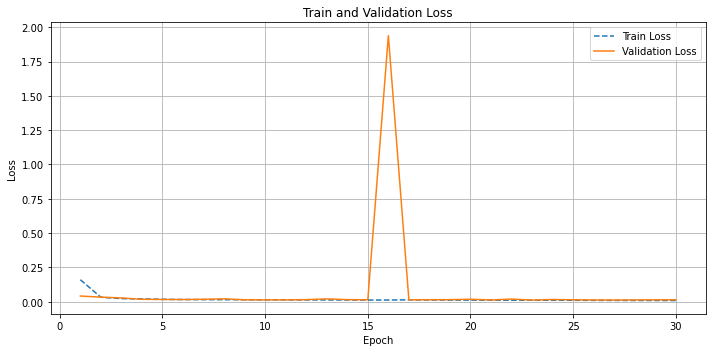

In [6]:
train_model(model.to(device), train_loader, test_loader, device, save_path, num_epochs=30, lr=1e-3)

## deeplabv3

# Inference phase

/users/nfs/Etu3/21402333/INRAE_Project/Segmentation_methods/../Segmentation_methods/utils.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.lo

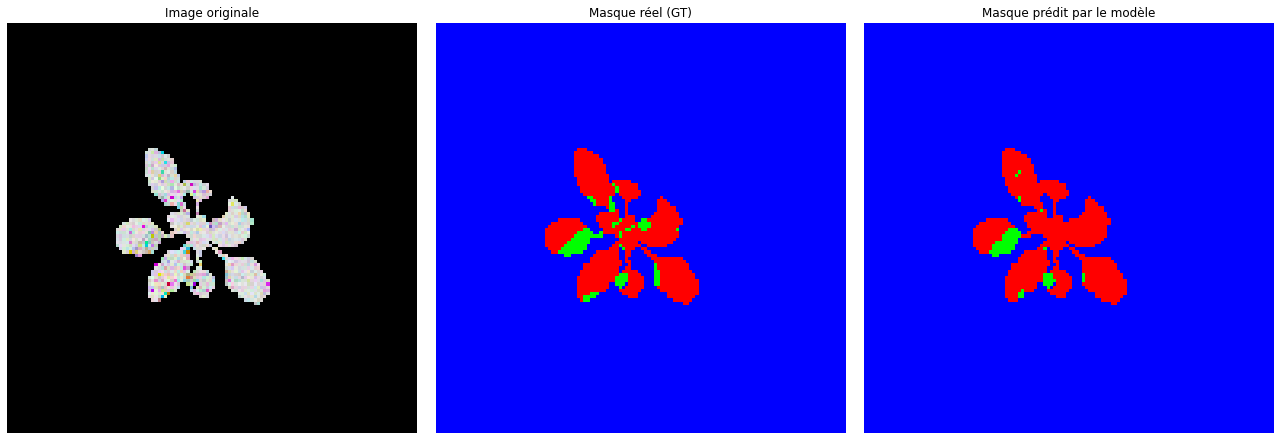

In [7]:
inference(model, test_loader, device, save_path)
